# UFO 포멧을 COCO 포멧으로 변경합니다.

In [9]:
import os
import json
from PIL import Image

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

def convert_ufo_to_coco(ufo_json_path, images_dir, output_coco_json_path):
    with open(ufo_json_path, 'r') as f:
        ufo_data = json.load(f)

    coco = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_set = {}
    category_id = 1  # 카테고리 ID 초기화
    annotation_id = 1

    # 카테고리 추가 (필요에 따라 수정 가능)
    category_name = "text"  # 모든 어노테이션을 'text' 카테고리로 지정
    category_set[category_name] = category_id
    coco["categories"].append({
        "id": category_id,
        "name": category_name,
        "supercategory": "none"
    })

    images_data = ufo_data.get('images', {})
    for image_id, (file_name, image_info) in enumerate(images_data.items(), start=1):
        image_path = os.path.join(images_dir, file_name)
        if not os.path.exists(image_path):
            print(f"이미지 파일이 존재하지 않습니다: {image_path}")
            continue  # 또는 에러 처리

        width, height = get_image_size(image_path)

        coco_image = {
            "id": image_id,
            "file_name": file_name,
            "width": width,
            "height": height
        }
        coco["images"].append(coco_image)

        words = image_info.get('words', {})
        for word_id, word_info in words.items():
            transcription = word_info.get('transcription', '')
            points = word_info.get('points', [])
            if not points:
                print(f"포인트 정보가 없습니다: {word_info}")
                continue  # 또는 에러 처리

            # 폴리곤 좌표에서 bbox 계산
            x_coords = [pt[0] for pt in points]
            y_coords = [pt[1] for pt in points]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

            area = bbox[2] * bbox[3]

            # 폴리곤 좌표를 1차원 리스트로 변환하여 segmentation 필드에 사용
            segmentation = [sum(points, [])]

            coco_annotation = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": bbox,
                "area": area,
                "iscrowd": 0,
                "segmentation": segmentation
            }
            coco["annotations"].append(coco_annotation)
            annotation_id += 1

    # 출력 디렉토리 생성
    output_dir = os.path.dirname(output_coco_json_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(output_coco_json_path, 'w') as f:
        json.dump(coco, f, indent=4)

    print(f"변환 완료! COCO 포맷 파일이 저장되었습니다: {output_coco_json_path}")

# 사용 예제
ufo_json_path = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/ufo/train.json'  # UFO 포맷 JSON 파일 경로
images_dir = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/img/train'  # 이미지가 저장된 디렉토리
output_coco_json_path = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/coco/train.json'  # 출력할 COCO 포맷 JSON 파일 경로

convert_ufo_to_coco(ufo_json_path, images_dir, output_coco_json_path)


포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}
포인트 정보가 없습니다: {'points': [], 'transcription': ''}


# COCO 포멧을 활용해서 시각화를 진행합니다.
#### ID를 뜨게해서 COCO에서 확인이 가능합니다. ( --- 을 문자로 인식하는 경우 id를 보고 지우면된다. )

In [16]:
import os
import json
import cv2

def load_coco_json(coco_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

def create_category_mapping(coco_data):
    category_mapping = {}
    for category in coco_data.get('categories', []):
        category_mapping[category['id']] = category['name']
    return category_mapping

def draw_bounding_boxes_on_image(image_path, annotations, category_mapping, output_path):
    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        print(f"이미지를 열 수 없습니다: {image_path}")
        return
    
    for ann in annotations:
        bbox = ann.get('bbox', [])
        category_id = ann.get('category_id')
        annotation_id = ann.get('id', 'N/A')  # 어노테이션 ID 가져오기
        category_name = category_mapping.get(category_id, 'N/A')
        
        if len(bbox) != 4:
            print(f"잘못된 bbox 형식: {bbox} in {image_path}")
            continue
        
        x, y, width, height = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + width), int(y + height)
        
        # 바운딩 박스 그리기
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        
        # 라벨 그리기 (카테고리 이름과 어노테이션 ID 포함)
        label = f"{category_name} ({annotation_id})"
        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(image, (x1, y1 - text_height - baseline), (x1 + text_width, y1), (0, 255, 0), -1)
        cv2.putText(image, label, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # 이미지 저장
    cv2.imwrite(output_path, image)
    print(f"바운딩 박스가 그려진 이미지가 저장되었습니다: {output_path}")

def process_coco_annotations(coco_json_path, images_dir, output_dir):
    # COCO JSON 로드
    coco_data = load_coco_json(coco_json_path)
    
    # 카테고리 매핑 생성
    category_mapping = create_category_mapping(coco_data)
    
    # 이미지 ID별 어노테이션 매핑
    annotations_mapping = {}
    for ann in coco_data.get('annotations', []):
        image_id = ann.get('image_id')
        if image_id not in annotations_mapping:
            annotations_mapping[image_id] = []
        annotations_mapping[image_id].append(ann)
    
    # 이미지 ID별 파일 이름 매핑
    image_id_to_filename = {}
    for img in coco_data.get('images', []):
        image_id_to_filename[img['id']] = img['file_name']
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 각 이미지에 대해 바운딩 박스 그리기
    for image_id, file_name in image_id_to_filename.items():
        image_path = os.path.join(images_dir, file_name)
        output_path = os.path.join(output_dir, file_name)
        
        annotations = annotations_mapping.get(image_id, [])
        if not annotations:
            print(f"어노테이션이 없습니다: {file_name}")
            continue
        
        draw_bounding_boxes_on_image(image_path, annotations, category_mapping, output_path)

    print("모든 이미지에 바운딩 박스 그리기가 완료되었습니다.")

# 사용 예제
coco_json_path = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/coco/train.json'  # COCO 포맷 JSON 파일 경로
images_dir = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img/train'  # 원본 이미지가 저장된 디렉토리
output_dir = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train'  # 바운딩 박스가 그려진 이미지를 저장할 디렉토리

process_coco_annotations(coco_json_path, images_dir, output_dir)


바운딩 박스가 그려진 이미지가 저장되었습니다: /data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train/extractor.vi.in_house.appen_001105_page0001.jpg
바운딩 박스가 그려진 이미지가 저장되었습니다: /data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train/extractor.vi.in_house.appen_000212_page0001.jpg
바운딩 박스가 그려진 이미지가 저장되었습니다: /data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train/extractor.vi.in_house.appen_000961_page0001.jpg
바운딩 박스가 그려진 이미지가 저장되었습니다: /data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train/extractor.vi.in_house.appen_000489_page0001.jpg
바운딩 박스가 그려진 이미지가 저장되었습니다: /data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train/extractor.vi.in_house.appen_000750_page0001.jpg
바운딩 박스가 그려진 이미지가 저장되었습니다: /data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/vietnamese_receipt/img_with_bboxes/train/extr

# Gray Scale 이미지

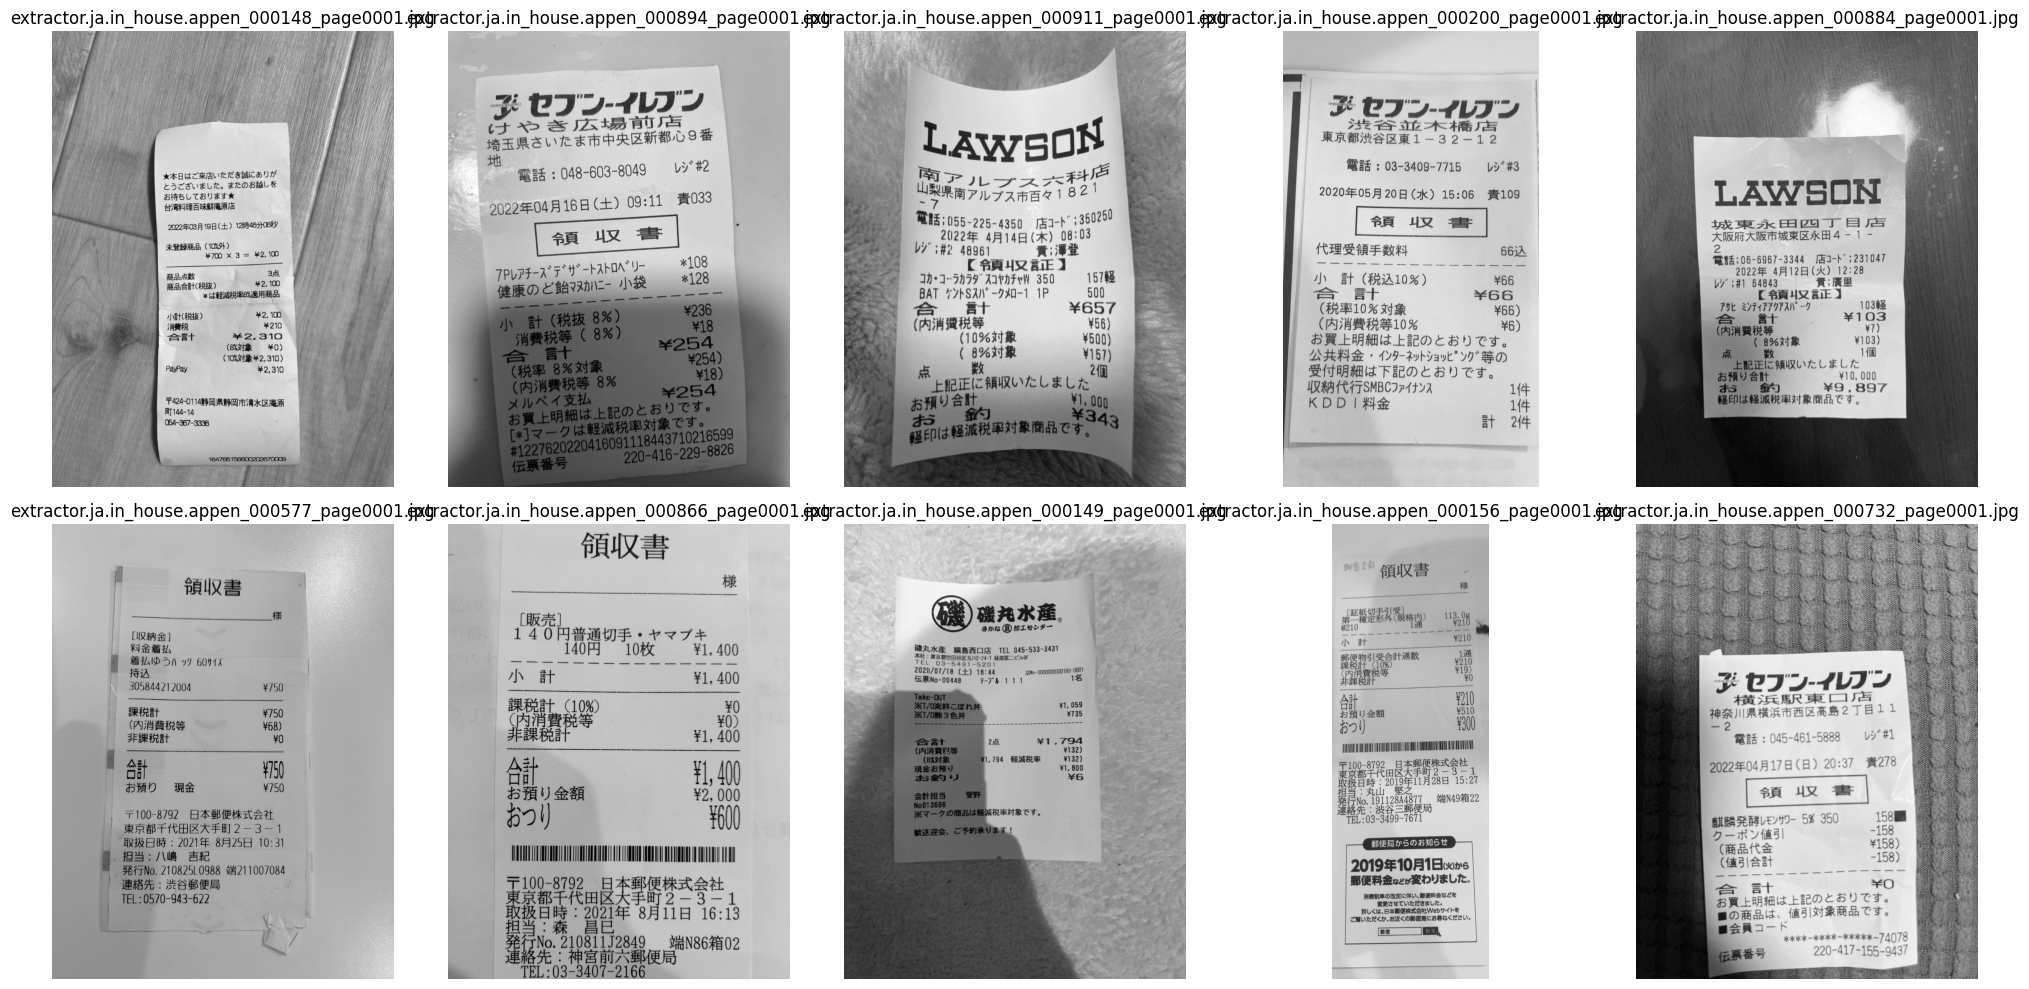

In [18]:
import os
import json
import cv2
import random
import matplotlib.pyplot as plt

def load_coco_json(coco_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

def get_image_filenames(coco_data):
    return [img['file_name'] for img in coco_data.get('images', [])]

def display_random_grayscale_images(images_dir, image_filenames, num_images=10):
    if len(image_filenames) < num_images:
        num_images = len(image_filenames)
        print(f"전체 이미지 수가 {num_images}보다 적습니다. {num_images}개의 이미지만 표시합니다.")
    
    selected_filenames = random.sample(image_filenames, num_images)
    
    plt.figure(figsize=(20, 10))
    
    for idx, file_name in enumerate(selected_filenames, start=1):
        image_path = os.path.join(images_dir, file_name)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"이미지를 열 수 없습니다: {image_path}")
            continue
        
        # 그레이스케일로 변환
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 이미지 시각화
        plt.subplot(2, 5, idx)  # 2행 5열의 그리드로 설정
        plt.imshow(gray_image, cmap='gray')
        plt.title(file_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 사용 예제
coco_json_path = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/coco/train.json'  # COCO 포맷 JSON 파일 경로
images_dir = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/img/train'  # 이미지가 저장된 디렉토리

# COCO JSON 파일 로드
coco_data = load_coco_json(coco_json_path)

# 이미지 파일 이름 목록 추출
image_filenames = get_image_filenames(coco_data)

# 랜덤으로 10개 이미지 그레이스케일로 시각화
display_random_grayscale_images(images_dir, image_filenames, num_images=10)


# sharp 필터 적용하여 테두리 강화

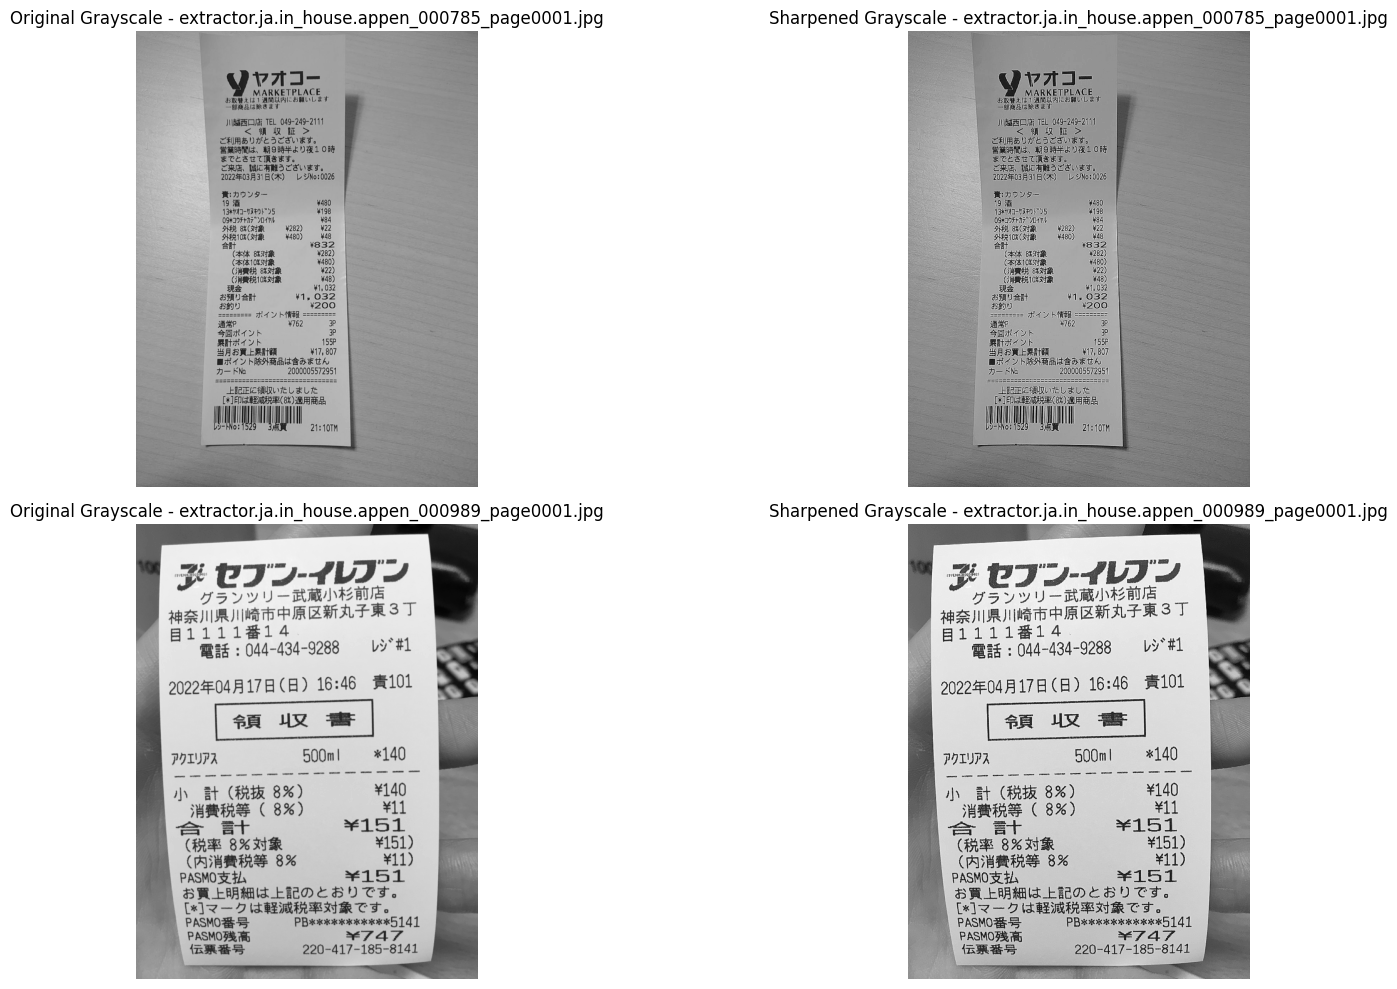

In [21]:
import os
import json
import cv2
import random
import numpy as np  # NumPy 임포트
import matplotlib.pyplot as plt

def load_coco_json(coco_json_path):
    """
    COCO 포맷의 JSON 파일을 로드합니다.
    
    Args:
        coco_json_path (str): COCO JSON 파일의 경로.
    
    Returns:
        dict: 로드된 COCO 데이터.
    """
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

def get_image_filenames(coco_data):
    """
    COCO 데이터에서 이미지 파일 이름 목록을 추출합니다.
    
    Args:
        coco_data (dict): 로드된 COCO 데이터.
    
    Returns:
        list: 이미지 파일 이름 목록.
    """
    return [img['file_name'] for img in coco_data.get('images', [])]

def display_comparison_grayscale_images(images_dir, image_filenames, num_images=2):
    """
    랜덤으로 선택된 두 이미지를 그레이스케일로 변환하고 샤프닝 필터를 적용한 후 원본과 비교하여 시각화합니다.
    
    Args:
        images_dir (str): 이미지가 저장된 디렉토리 경로.
        image_filenames (list): 이미지 파일 이름 목록.
        num_images (int): 시각화할 이미지 수. 기본값은 2.
    """
    # 선택할 이미지 수가 전체 이미지 수보다 많을 경우 조정
    if len(image_filenames) < num_images:
        num_images = len(image_filenames)
        print(f"전체 이미지 수가 {num_images}보다 적습니다. {num_images}개의 이미지만 표시합니다.")
    
    # 랜덤으로 고유한 이미지 파일 이름 선택
    selected_filenames = random.sample(image_filenames, num_images)
    
    # matplotlib 그림 설정 (각 이미지당 원본과 샤프닝된 이미지를 나란히 표시)
    plt.figure(figsize=(10 * num_images, 10))
    
    # 샤프닝 커널 정의
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    
    for idx, file_name in enumerate(selected_filenames, start=1):
        image_path = os.path.join(images_dir, file_name)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"이미지를 열 수 없습니다: {image_path}")
            continue
        
        # 그레이스케일로 변환
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 샤프닝 필터 적용
        sharpened_image = cv2.filter2D(gray_image, -1, kernel)
        
        # 원본 그레이스케일 이미지 시각화
        plt.subplot(num_images, 2, 2 * idx - 1)
        plt.imshow(gray_image, cmap='gray')
        plt.title(f"Original Grayscale - {file_name}")
        plt.axis('off')
        
        # 샤프닝된 이미지 시각화
        plt.subplot(num_images, 2, 2 * idx)
        plt.imshow(sharpened_image, cmap='gray')
        plt.title(f"Sharpened Grayscale - {file_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 사용 예제
coco_json_path = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/coco/train.json'  # COCO 포맷 JSON 파일 경로
images_dir = '/data/ephemeral/home/level2-cv-datacentric-cv-12/code/data/japanese_receipt/img/train'  # 이미지가 저장된 디렉토리

# COCO JSON 파일 로드
coco_data = load_coco_json(coco_json_path)

# 이미지 파일 이름 목록 추출
image_filenames = get_image_filenames(coco_data)

# 랜덤으로 2개 이미지 그레이스케일로 샤프닝 필터 적용 후 비교 시각화
display_comparison_grayscale_images(images_dir, image_filenames, num_images=2)


In [2]:
pip install git+https://github.com/huggingface/diffusers.git


  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-qoo62_29
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-qoo62_29
  Resolved https://github.com/huggingface/diffusers.git to commit 0d1d267b12e47b40b0e8f265339c76e0f45f8c49
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.32.0.dev0-py3-none-any.whl size=2899257 sha256=db68619b6b85e5d73777191c07467778ec2864030234eca40e36e730db097119
  Stored in directory: /tmp/pip-ephem-wheel-cache-_l6ba7cw/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.11.1
    Uninstalling diffusers-0.11.1:
      Successfully uninstalled diffusers-0.11.1
Note: you may need to restart the kernel to use updated pa

In [1]:
import requests
from PIL import Image
from io import BytesIO
from diffusers import LDMSuperResolutionPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/ldm-super-resolution-4x-openimages"

# 모델 로드
pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

# 이미지 다운로드 및 열기
url = "https://user-images.githubusercontent.com/38061659/199705896-b48e17b8-b231-47cd-a270-4ffa5a93fa3e.png"
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img = low_res_img.resize((128, 128))

# 슈퍼 레졸루션 적용
upscaled_image = pipeline(low_res_img, num_inference_steps=100, eta=1).images[0]

# 결과 이미지 저장
upscaled_image.save("ldm_generated_image.png")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]


RuntimeError: Failed to import diffusers.pipelines.latent_diffusion.pipeline_latent_diffusion_superresolution because of the following error (look up to see its traceback):
Failed to import diffusers.models.unets.unet_2d because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.unet because of the following error (look up to see its traceback):
cannot import name 'CLIPTextModelWithProjection' from 'transformers' (/opt/conda/lib/python3.10/site-packages/transformers/__init__.py)